# 평균 - 분산 최적화
- 리샘플링 기법 활용
- 과거 데이터로부터 무작위 추출을 하여, 새로운 샘플을 만들고 적용해보는 것
- 이를 통해 평균적인 공분산 등 만들어 내는 것

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

In [6]:
# 티커 리스트 정의
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

# 데이터 다운
etf = yf.Tickers(tickers)
data = etf.history(start="2015-01-01", actions=False)

data = data['Close']
data.head(3)

[*********************100%%**********************]  9 of 9 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2015-01-02,40.771942,55.437855,16.930059,47.938213,36.769955,38.382538,35.621895,59.491104,64.595932
2015-01-05,39.732727,53.144497,16.574074,46.818432,36.208645,38.112625,35.186390,59.187698,63.360481
2015-01-06,39.380737,52.363792,16.320772,46.241577,35.772083,38.064999,35.208908,58.988354,62.729198


In [7]:
# 일별 수익률
rets = data.pct_change().fillna(0)

# 수익률 벡터
ret_vec = rets.mean() * 252

# 공분산 행렬
cov_mat = rets.cov() * 252

In [15]:
# 효율적 경계선 리샘플링 함수
def resampled_efficient_frontier(ret_vec, cov_mat, size=252, N_path=50, N_point=50, resampling=True):
    # 자산 개수
    n = len(ret_vec)
    
    if resampling:
        # 리샘플링을 위한 시뮬레이션
        ret_vec_stack = np.zeros((N_path, len(ret_vec)))
        cov_mat_stack = np.zeros((N_path, len(ret_vec), len(ret_vec)))
        
        for i in range(N_path):
            # 리샘플링 경로 생성
            # 다변량 정규분포로부터 임의의 난수 추출
            data = np.random.multivariate_normal(ret_vec, cov_mat, size=size)
            
            # 새롬게 만들어진 기대수익률 벡터
            ret_vec_i = data.mean(axis=0)
            ret_vec_stack[i, :] = ret_vec_i
            
            # 새롬게 만들어진 공분산 행렬
            cov_mat_i = np.cov(data.T)
            cov_mat_stack[i, :, :] = cov_mat_i
        
        # 새로 업데이트 된 기대수익률 벡터와 공분산 행렬
        new_ret_vec = ret_vec_stack.mean(axis=0)
        new_cov_mat = cov_mat_stack.mean(axis=0)
    else:
        new_ret_vec = ret_vec
        new_cov_mat = cov_mat
        
    # 목적함수
    def obj_func(weights):
        # 투가 가중치
        weights = np.array(weights)
        
        # 포트폴리오 변동성
        pvol = np.sqrt(np.dot(weights.T, np.dot(new_cov_mat, weights)))
        
        return pvol
    
    # 수익률 수준별 포트폴리오 최적화 수행
    trets = np.linspace(0.1, 0.15, N_point)
    tvols = []
    
    # 난수를 활용해 임의의 가중치 데이터 생성
    weights = np.random.random(n)
    weights /= np.sum(weights)
    
    # for 문을 돌려 각 목표 수익률에 맞는 포트폴리오 변동성 레벨을 계산하기
    for tret in trets:
        # 투자 가중치 초기값 = 동일가중
        init_guess = np.repeat(1/n, n)
        
        # 제약조건(포트폴리오 목표수익률, 현금 보유 비중 0)
        cons = ({'type' : 'eq', 'fun': lambda x: np.array(np.sum(new_ret_vec * x)) - tret},
                {'type' : 'eq', 'fun': lambda x: np.sum(x) - 1})
        
        # 자산별 경계조건(숏 포지션 불가능)
        bnds = tuple((0.0, 1.0) for x in weights)
        
        # 최적화 알고리즘 수행
        res = sco.minimize(obj_func,
                          init_guess,
                          method='SLSQP',
                          bounds=bnds,
                          constraints=cons)
        # 최적화 알고리즘 통해 찾아낸 최적 포트폴리오의 변동성 값을 리스트에 저장
        tvols.append(res['fun'])
    
    # 포트폴리오 변동성 리스트를 배열로 변환
    tvols = np.array(tvols)
    
    return trets, tvols

In [16]:
# 리샘플링 O
new_trets, new_tvols = resampled_efficient_frontier(ret_vec, cov_mat)

# 리샘플링 X
trets, tvols = resampled_efficient_frontier(ret_vec, cov_mat, resampling=False)

### 시각화

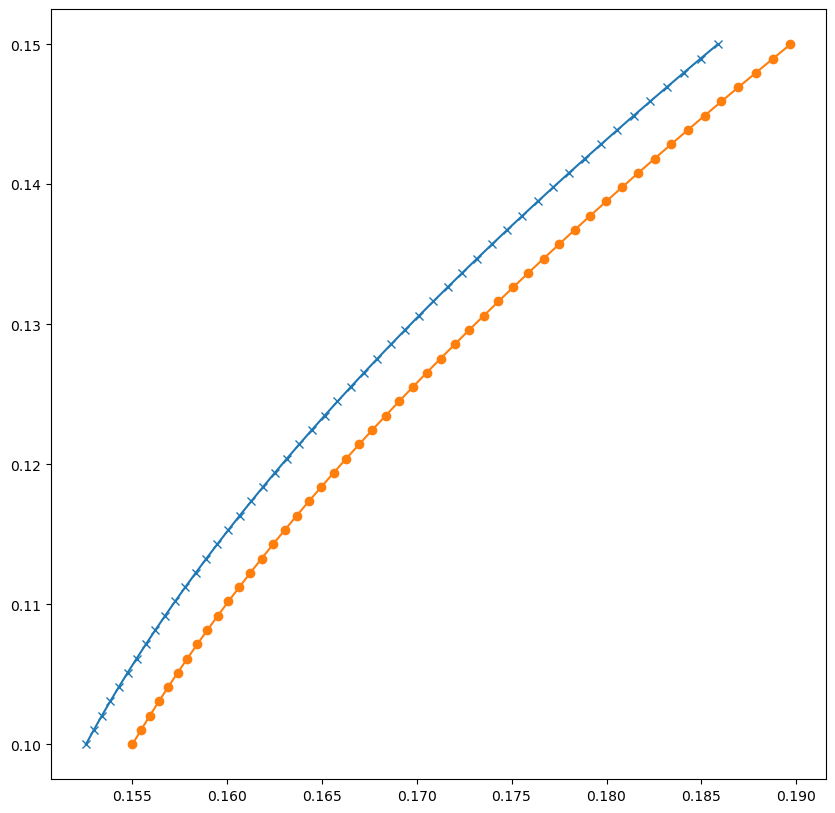

In [17]:
plt.figure(figsize=(10,10))
plt.plot(tvols, trets, marker='x', label='Original')
plt.plot(new_tvols, new_trets, marker='o', label='Original')